In [35]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)
print("Files in the directory:")
for filename in os.listdir(path):
    if os.path.isfile(os.path.join(path, filename)):
        print(filename)

Path to dataset files: /Users/ssgrummo/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1
Files in the directory:
Fake.csv
True.csv


In [36]:
import pandas as pd
# Load the data into a DataFrame
df_fake = pd.read_csv(os.path.join(path, "fake.csv"))
df_true = pd.read_csv(os.path.join(path, "true.csv"))
print("Shape of fake dataset:", df_fake.shape)
print("Shape of true dataset:", df_true.shape)

Shape of fake dataset: (23481, 4)
Shape of true dataset: (21417, 4)


In [37]:
combined_df = pd.concat([df_fake, df_true], ignore_index=True)

combined_df['is_bs'] = combined_df.apply(lambda row: 1 if row.name in df_fake.index else 0, axis=1)

print("Shape of combined dataset:", combined_df.shape)
combined_df.head(5)

Shape of combined dataset: (44898, 5)


,title,text,subject,date,is_bs
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [38]:
# This is a list of all the legitimate news articles that are not clearly labeled from Reuters. 
# This data will be removed from the training and testing dataset
unclean_negs = combined_df[(~combined_df['text'].str.contains('\(Reuters\) -', case=True) & (combined_df['is_bs'] == 0))]
print("Shape of unclean legitmate articles:", unclean_negs.shape)
unclean_negs.head(5)

Shape of unclean legitmate articles: (171, 5)


,title,text,subject,date,is_bs
23488,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",0
23489,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",0
23493,Factbox: Trump on Twitter (Dec 28) - Vanity Fa...,The following statements were posted to the ve...,politicsNews,"December 28, 2017",0
23494,"Trump on Twitter (Dec 27) - Trump, Iraq, Syria",The following statements were posted to the ve...,politicsNews,"December 28, 2017",0
23498,"Trump on Twitter (Dec 26) - Hillary Clinton, T...",The following statements were posted to the ve...,politicsNews,"December 26, 2017",0


### Clean the Dataset

In [39]:
## Remove articles taht just quote tweets

mask = ~combined_df.index.isin(unclean_negs.index)

df_result = combined_df[mask]
df = df_result[['text', 'is_bs']]
print("Shape of final dataset:", df.shape)


Shape of final dataset: (44727, 2)


In [40]:
df['text'] = df['text'].str.replace(r'^.*\(Reuters\)\s*-\s*', '', regex=True)

/var/folders/t7/7_zptf5x1vbbszvmqj98wzk80000gn/T/ipykernel_75221/4133627834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.replace(r'^.*\(Reuters\)\s*-\s*', '', regex=True)


### Remove Named Entities from Text

In [41]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

device = "mps" if torch.backends.mps.is_available() else "cpu"
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
ner = pipeline("ner", model=model, tokenizer=tokenizer, device=0 if device == "mps" else -1, grouped_entities=True)

def extract_entities(text):
    doc = ner(text)
    return [(ent['word'], ent['entity_group']) for ent in doc]

df['entities'] = df['text'].apply(extract_entities)


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy

In [42]:
df.to_csv("../data/raw/processed_data.csv", index=False)

In [43]:
# Explode entity list
df_exploded = df.explode("entities")

# Split each tuple into two new columns
df_exploded[['entity', 'entity_group']] = pd.DataFrame(df_exploded['entities'].tolist(), index=df_exploded.index)

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_k_entities(df, entity_group, k=10):
    df_filtered = df[df['entity_group'] == entity_group]

    top_bs = (
        df_filtered[df_filtered['is_bs'] == 1]
        .groupby('entity').size()
        .nlargest(k)
    )

    top_nonbs = (
        df_filtered[df_filtered['is_bs'] == 0]
        .groupby('entity').size()
        .nlargest(k)
    )

    # Merge for comparison (fill missing with 0s)
    merged = pd.concat([top_bs, top_nonbs], axis=1, keys=['is_bs=1', 'is_bs=0']).fillna(0)

    # Plotting
    merged.sort_values('is_bs=1', ascending=True).plot(kind='barh', figsize=(10, 6))
    plt.title(f"Top {k} Entities in {entity_group} (Fake vs Real)")
    plt.xlabel("Count")
    plt.ylabel("Entity")
    plt.tight_layout()
    plt.show()


In [45]:
df_exploded['entity_group'].unique()

array(['PER', 'MISC', 'LOC', 'ORG', None], dtype=object)

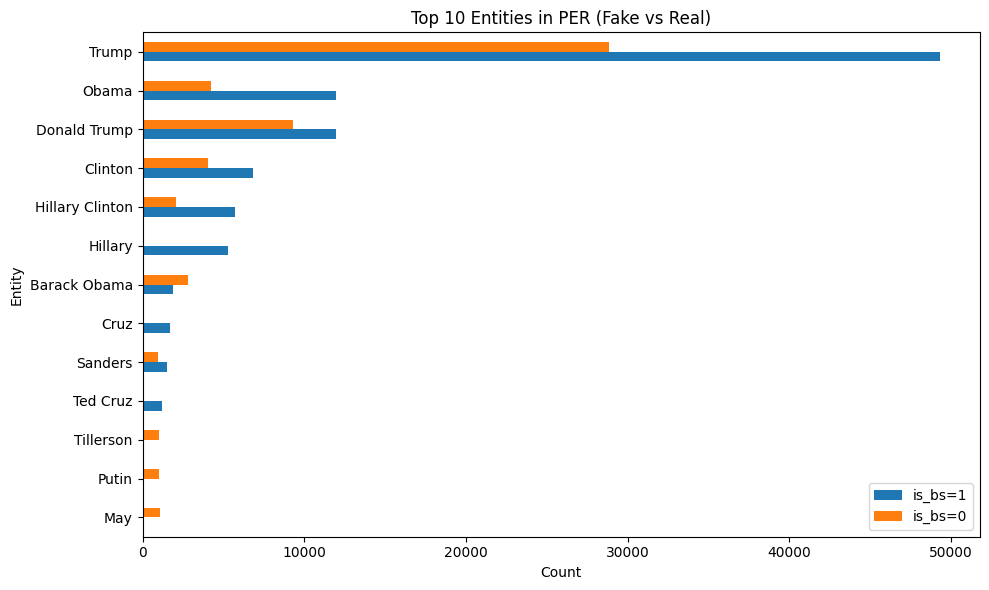

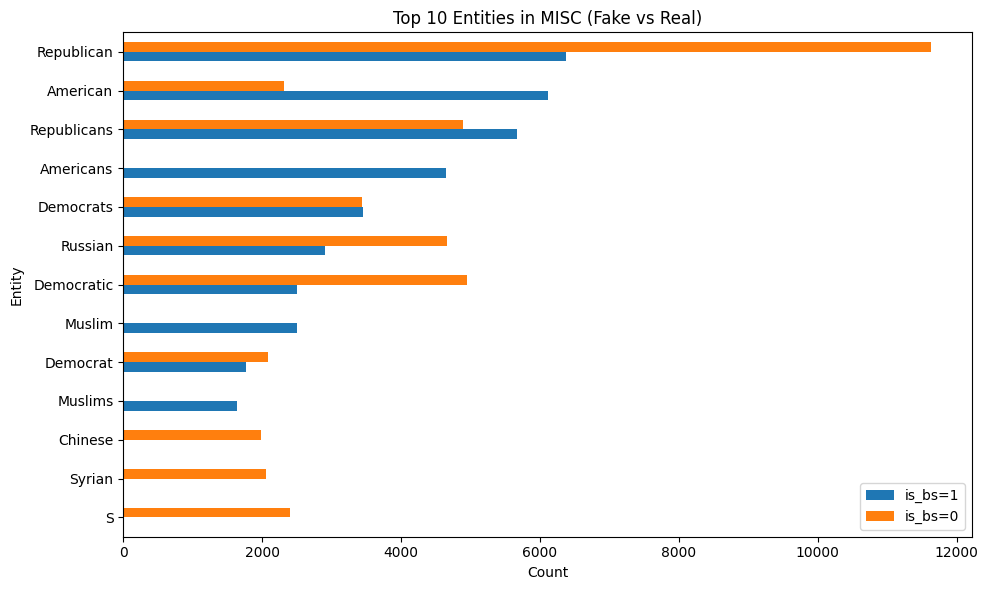

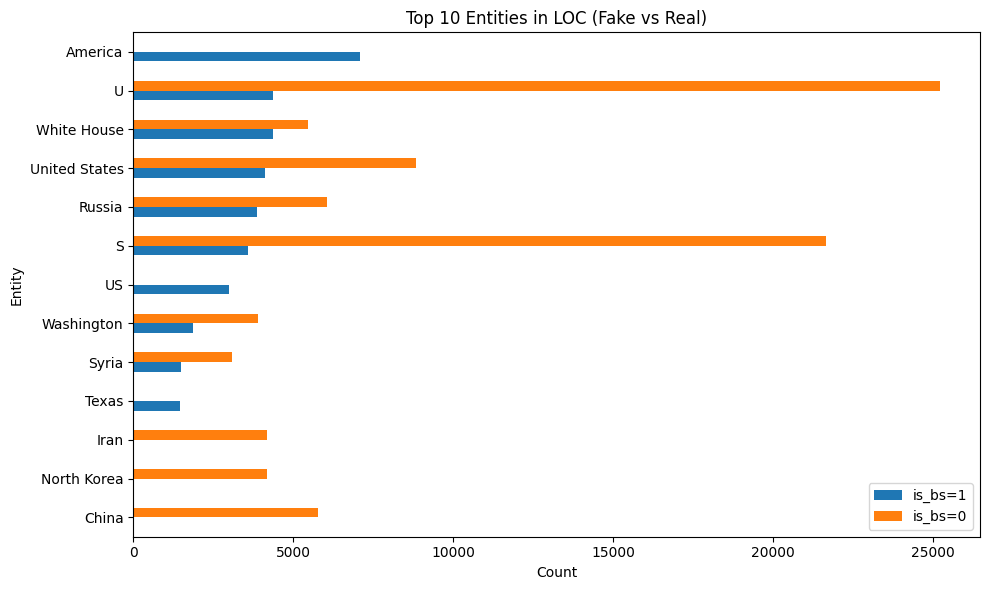

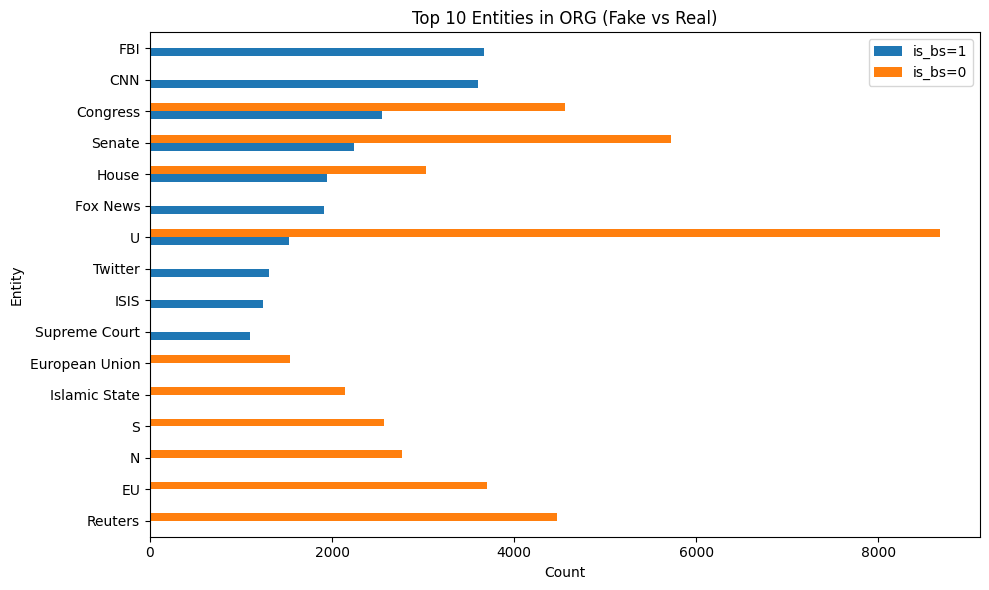

In [46]:
df_exploded = df_exploded[df_exploded['entity_group'].isin(['PER', 'MISC', 'LOC', 'ORG'])]
for eg in df_exploded['entity_group'].unique():
    plot_top_k_entities(df_exploded, eg, k=10)


### Mask Named Entities in the Data Set

In [47]:
import re
import random
import hashlib

def deterministic_seed(text):
    # Create a deterministic integer seed from the text using SHA256
    return int(hashlib.sha256(text.encode('utf-8')).hexdigest(), 16) % (10**8)

def mask_entities_per_row(text, entities):
    # Set a deterministic seed per row
    random.seed(deterministic_seed(text))

    mask_map = {}
    used_ids = set()
    
    # Replace longer entities first to avoid substring issues
    entities = sorted(entities, key=lambda x: -len(x[0]))

    for ent_text, ent_group in entities:
        if ent_text not in mask_map:
            # Generate a new random unused mask ID
            while True:
                mask_id = random.randint(1, 99999)
                if mask_id not in used_ids:
                    used_ids.add(mask_id)
                    break
            mask_token = f"<MASK_{mask_id}>"
            mask_map[ent_text] = mask_token

    # Replace all entity texts with their corresponding mask in the text
    for ent_text, mask_token in mask_map.items():
        pattern = re.compile(re.escape(ent_text))
        text = pattern.sub(mask_token, text)

    return text


In [48]:
df['masked_text'] = df.apply(lambda row: mask_entities_per_row(row['text'], row['entities']), axis=1)

final_df = df[['masked_text','is_bs']]

final_df['text'] = final_df['masked_text']
final_df.drop(columns=['masked_text'], inplace=True)

final_df.to_csv("../data/raw/initial_data.csv", index=False)

/var/folders/t7/7_zptf5x1vbbszvmqj98wzk80000gn/T/ipykernel_75221/2068480640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['masked_text'] = df.apply(lambda row: mask_entities_per_row(row['text'], row['entities']), axis=1)
/var/folders/t7/7_zptf5x1vbbszvmqj98wzk80000gn/T/ipykernel_75221/2068480640.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['text'] = final_df['masked_text']
/var/folders/t7/7_zptf5x1vbbszvmqj98wzk80000gn/T/ipykernel_75221/2068480640.py:6: SettingWithCopyWarning: 
A va